## Complex Step Approximation to Compute Sensitivity of a Simple ODE System

I came across this interesting [blog post](https://nhigham.com/2020/10/06/what-is-the-complex-step-approximation/) by Nick Higham on complex step approximation to compute derivatives that has high accuracy and can use very small step sizes (even $h = 10^{-100}$ !! without running into round-off issues). The main result (which uses complex arithmetic) is:
$$
f'(x) \approx Im\frac{f(x + ih)}{h}
$$
I wanted to try it with a simple ODE system (with $h=10^{-20}$) and chose a simple series reaction $A \rightarrow B \rightarrow C$. The interesting feature (at least for this simple system) is that we need to do minimal change to scipy code to use complex numbers and get the sensitivities.

In [54]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

In [55]:
def rate(t, c, p):
    k1 = p[0]
    k2 = p[1]
    ca = c[0]
    cb = c[1]
    cc = c[2]
    
    dca = -k1 * ca
    dcb = k1 * ca - k2 * cb
    dcc = k2 * cb
    
    return [dca, dcb, dcc]

In [56]:
sol = solve_ivp(rate, [0, 5.0], [1.0, 0.0, 0.0], method = 'BDF', args = ([2.0, 1.0],))

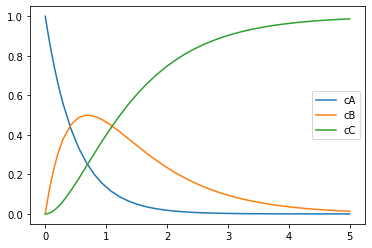

In [57]:
fig, ax = plt.subplots()
ax.plot(sol.t, sol.y[0], label = "cA")
ax.plot(sol.t, sol.y[1], label = "cB")
ax.plot(sol.t, sol.y[2], label = "cC")
ax.legend()

In [58]:
h = 1e-20
sol_k1_pert = solve_ivp(rate, [0, 5.0], [complex(1, 0), complex(0, 0), complex(0, 0)], 
                 method = 'BDF', args = ([complex(2.0, h), complex(1.0, 0.0)],))
sol_k2_pert = solve_ivp(rate, [0, 5.0], [complex(1, 0), complex(0, 0), complex(0, 0)], 
                 method = 'BDF', args = ([complex(2.0, 0.0), complex(1.0, h)],))

In [59]:
sens_c_k1_f = sol_k1_pert.y/h
sens_c_k1 = sens_c_k1_f.imag

In [60]:
sens_c_k2_f = sol_k2_pert.y/h
sens_c_k2 = sens_c_k2_f.imag

In [61]:
# Calculate analytical sensitivity of ca to k1 and k2
tgrid = np.linspace(0.0, 5.0)
kfix = [2.0, 1.0]
dca_dk1_analy = -tgrid * np.exp(-kfix[0] * tgrid)
dca_dk2_analy = 0
# Calculate analytical sensitivity of cb to k1 and k2
dcb_dk1_analy = (kfix[1]/(kfix[1] - kfix[0])**2)*(np.exp(-kfix[0] * tgrid) - np.exp(-kfix[1] * tgrid)) - \
                     (kfix[0] * tgrid / (kfix[1] - kfix[0]))*np.exp(-kfix[0] * tgrid)
dcb_dk2_analy = (-kfix[0]/(kfix[1] - kfix[0])**2)*(np.exp(-kfix[0] * tgrid) - np.exp(-kfix[1] * tgrid)) + \
                     (kfix[0] * tgrid / (kfix[1] - kfix[0]))*np.exp(-kfix[1] * tgrid)

# Calculate analytical sensitivity of cc to k1 and k2
dcc_dk1_analy = -dca_dk1_analy - dcb_dk1_analy
dcc_dk2_analy = -dca_dk2_analy - dcb_dk2_analy

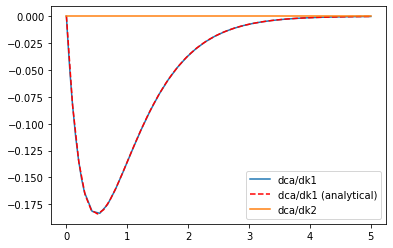

In [62]:
# plot sensitivity of ca to k1 and k2
fig, ax = plt.subplots()
ax.plot(sol_k1_pert.t, sens_c_k1[0,:], label = 'dca/dk1')
ax.plot(tgrid, dca_dk1_analy, '--r', label = 'dca/dk1 (analytical)')
ax.plot(sol_k2_pert.t, sens_c_k2[0,:], label = 'dca/dk2')
ax.legend()

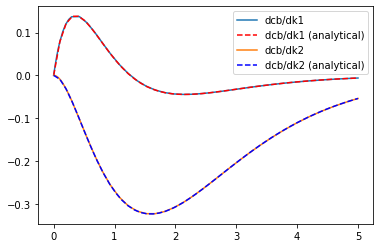

In [63]:
# plot sensitivity of cb to k1 and k2
fig, ax = plt.subplots()
ax.plot(sol_k1_pert.t, sens_c_k1[1,:], label = 'dcb/dk1')
ax.plot(tgrid, dcb_dk1_analy, '--r', label = 'dcb/dk1 (analytical)')
ax.plot(sol_k2_pert.t, sens_c_k2[1,:], label = 'dcb/dk2')
ax.plot(tgrid, dcb_dk2_analy, '--b', label = 'dcb/dk2 (analytical)')
ax.legend()

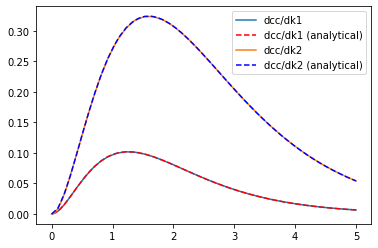

In [64]:
# plot sensitivity of cc to k1 and k2
fig, ax = plt.subplots()
ax.plot(sol_k1_pert.t, sens_c_k1[2,:], label = 'dcc/dk1')
ax.plot(tgrid, dcc_dk1_analy, '--r', label = 'dcc/dk1 (analytical)')
ax.plot(sol_k2_pert.t, sens_c_k2[2,:], label = 'dcc/dk2')
ax.plot(tgrid, dcc_dk2_analy, '--b', label = 'dcc/dk2 (analytical)')
ax.legend()